In [1]:
import pandas as pd
import numpy as np
import pydicom 
import os
import matplotlib.pyplot as plt

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border

from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize

import scipy

In [82]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [92]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
#     try:
#         slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
#     except:
#         slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
#     for s in slices:
#         s.SliceThickness = slice_thickness
        
    return slices

In [42]:
def smaller_scan(scan):
    
    n = int(round(len(scan)/28))
    smaller = []
    j=0
    while j < len(scan):
        smaller.append(scan[j])
        j += n
    return smaller

In [43]:
def load_smaller_scan(path):
    return smaller_scan(load_scan(path))

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
def crop_center(img):
    y,x = img.shape    
    return img[y//2 - 256:y//2 + 256,x//2 - 256:x//2 + 256]

def shape_512(array):
    
    array_512 = np.zeros([array.shape[0],512,512])
    
    for i in range(array.shape[0]):
        array_512[i] = crop_center(array[i])
        
    return array_512

In [54]:
def small_lung_slices(path):
    small = load_smaller_scan(path)
    imgs = get_pixels_hu(small)
    return shape_512(imgs)

In [127]:
path = 'train/' + 'ID00105637202208831864134'

imgs = small_lung_slices(path)

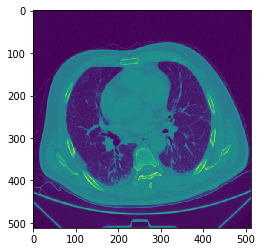

In [110]:
plt.imshow(imgs[15])

In [112]:
imgs[15].shape

(512, 512)

In [156]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

def best_lungmask(slices):
    img = make_lungmask(slices[1])
    pixel_nr = (img != 0).sum()
    nr = 1
    for i in range(2,len(slices)):
        tmp_img = make_lungmask(slices[i])
        tmp_pixel_nr = (tmp_img != 0).sum() 
        if tmp_pixel_nr > pixel_nr:
            img = tmp_img
            pixel_nr = tmp_pixel_nr
            nr = i
    return img, nr

In [157]:
np.argwhere(np.isnan(imgs[2])) 

array([], shape=(0, 2), dtype=int64)

In [158]:
def best_lung_slice(path):
    imgs = small_lung_slices(path)
    return best_lungmask(imgs)[0]

In [ ]:
patients = train.Patient.unique()

# problem with 'ID00105637202208831864134'

for pat in patients:
    np.savetxt('best_lung_slice/' + pat  + '.txt', best_lung_slice('train/' + pat)) 

In [93]:
def load_best_slices(path):
    ind = []
    for file in os.listdir(path):
        if file.split('.')[1] == 'txt':
            ind.append(file.split('.')[0])
        
    df = pd.DataFrame(index = ind, columns= ['CT'])
    for ind in df.index:
        df.loc[ind].CT = np.loadtxt(path + ind + '.txt')
    
    return df

#df = load_best_slices('best_lung_slice/')